In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px

import warnings
warnings.simplefilter("ignore")

import scipy.integrate as integrate

## <span id="top">Modelling</span>

1. [Detailed vs. Simplified Lightcurve](#m_diff)
2. [Hardness Ratio for LAT/GBM](#hard)
3. [Expected T90](#t90)
4. [Expected Anisotropy Ratio](#aniso)

We have so far modelled the simplified lightcurve in the Fitting notebook as follows:

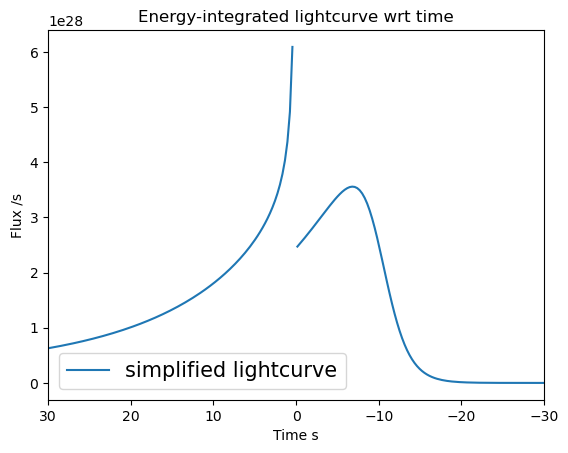

In [2]:
#GBM Energy Spectrum
Emin = 50*10**(-6) # GeV
Emax = 300*10**(-6) # GeV

# lifetime only, no spectrum.
# Norm * \frac{e^{(-t -\Delta)/tp } }{1 - e^{(-t - \Delta)/tm} }
afterglow = lambda tau, delta, t_m, t_p, normalization: (
    normalization * np.exp(-(1/t_p)*(tau-delta))/(1 + np.exp(-(1/t_m)*(tau-delta))))

# Simplifying lightcurve with powerlaw of index -.52
lightcurve = lambda tau, normalization = 1., index = .52: normalization*tau**(-index)

tau_s = np.linspace(30,0,100)
tau_a = np.linspace(30,-30,200)

s_curve = np.zeros(200)

fig, ax = plt.subplots()

s_curve[0:100] = lightcurve(tau_s, normalization = 2*1e28)

a_curve = afterglow(tau_a, -10, 1.5, 14, 5*1e28)

ax.plot(tau_a, s_curve + a_curve, label = 'simplified lightcurve')

ax.set_xlim(30,-30)

ax.set_xlabel("Time s")
ax.set_ylabel("Flux /s")
ax.set_title("Energy-integrated lightcurve wrt time")
ax.legend(prop={'size':15})
plt.show()

Let's try to replicate the above using the more complex models.

Paper: [BH evaporation models](https://arxiv.org/pdf/1510.04372.pdf)
- 3.3: Photon spectrum
- 3.4: Time-integrated photon spectrum
- 3.5: Light curve

[LAT and GBM detector energy ranges](https://hesperia.gsfc.nasa.gov/fermi_solar/summary_gbm_lat.htm):
- LAT: 20 MeV to 300 GeV
- Twelve GBM NaI: 8 keV to 1 MeV
- Two GBM BGO: 200 keV to 40 MeV

In [3]:
#GBM Energy Spectrum
Emin = 50*10**(-6) # GeV
Emax = 300*10**(-6) # GeV


theta_s = lambda x: 0.5 * (1+ np.tanh(10*x))

class EBH:
    
    def __init__(self):
        self.A = 6.339 * 10**23 # /GeV/s
        self.B = 1.1367 * 10**24 # /GeV/s
        self.x_c = 1.287 * 10**(-4)
        return
        
    def fluxdtdE_frag(self, x):
        return ( 
                ( self.A * x**(-3/2)  * ( 1 - theta_s(x - .3) ) ) + 
                ( self.B * np.exp(-x) * (x*(x+1))**(-1) * theta_s(x - .3) )
                )
    
    def fluxdtdE_direct(self, x):
        
        c = 1.13* 1e19 * x**6 / np.expm1(x) # * f
        
        # if x <= 2:
        #     f = 1
        # else:
        f = lambda x: np.exp( 
            (-0.0962 - 1.982 * (np.log(x) - 1.908))
            * (1 + np.tanh( 20 * (np.log(x) - 1.908) )))
        
        if isinstance(x, np.ndarray):
            # I kind of deprecated this np array option by changing the integrate fcn. to quad
            f = c*f(x)
            xi = np.where(x <= 2)[0]
            f[xi[0]:xi[-1]] = c[xi[0]:xi[-1]]
            return f
        else:
            if x <= 2.:
                return c*1.
            else:
                return c*f(x)
    
    def x(self, E, # Unitless energy /GeV
          tau = None, # Unitless remaining liftime /s
          mass = None): # Mass remaining in kg
        
        if tau is not None:
            f = lambda E, t: self.x_c * (E) * t**(1/3)
            tick = tau
        elif mass is not None:
            # x = E/kT
            # kT = 1.058 * 10e10kg / M_BH GeV
            # x = E * M_BH /  (1.058 * 10e10kg)
            f = lambda E, m: E/(1.058 * (10e10/m))
            tick = mass
        else:
            raise Exception('Provide a tau or mass.')
        
        
        if isinstance(tick, np.ndarray):
            # If we give a n-dim E and a m-dim tau
            # We want back a n x m array of x
            x = []
            for i in tick:
                x.append(f(E,i))
            return np.array(x)
        else:
            return f(E,tick)
    
    def convert_ticks(self, tau=None, mass=None):
        # x = E*M_BH / 1.058*10e10kg
        # x = x_c*E*t^1/3
        if tau is None:
            # t = [ M_BH / (x_c * 1.058*10e10) ]**3
            return ( mass / (self.x_c * 1.058 * 10e10) )**3
        elif mass is None:
            # M_BH = x_c*t^1/3 * 1.058*10e10
            return self.x_c * tau**(1/3) * 1.058*10e10
        else:
            raise Exception('Provide a tau or mass.')
    
    def spectrum(self, E, tau=None, mass=None, both=True, x=None):

        if x is None:
            if mass is None:
                x = self.x(E, tau=tau)
            elif tau is None:
                x = self.x(E, mass=mass)
            else:
                raise Exception('Provide a tau or mass')
        if both == 'primary':
            return self.fluxdtdE_direct(x)
        elif both == 'secondary': 
            return self.fluxdtdE_frag(x)
        else: 
            return self.fluxdtdE_frag(x) + self.fluxdtdE_direct(x)
        
    def lightcurve(self, energy_range, tau=None, mass=None): # Would prefer energy_range as a tuple pls
        
        if tau is not None:
            c = np.zeros(len(tau))
            for i,t in enumerate(tau):
                c[i] = integrate.quad(lambda e: self.spectrum(e, tau=t), energy_range[0], energy_range[-1])[0]
            return c
        elif mass is not None:
            c = np.zeros(len(mass))
            for i,m in enumerate(mass):
                c[i] = integrate.quad(lambda e: self.spectrum(e, mass=m), energy_range[0], energy_range[-1])[0]
            return c
        else:
            raise Exception('Provide a tau or mass.')

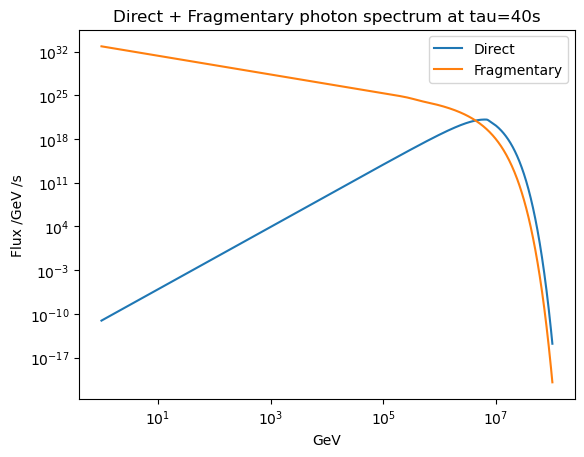

In [4]:
fig, ax = plt.subplots()

p_s = EBH()
energy_range = np.logspace(0, 8, 1000)

tau = EBH().convert_ticks(mass = 10**5)
x = EBH().x(energy_range, tau)

direct = p_s.spectrum(energy_range, tau=tau, both='primary')
ax.loglog(energy_range, direct, label = 'Direct')
fragmentary = p_s.spectrum(energy_range, tau=tau, both='secondary')
ax.loglog(energy_range, fragmentary, label = 'Fragmentary')

"""fig = px.line(pd.DataFrame({'energy_range':energy_range, 'direct':direct, 'frag':fragmentary, 'x':x}), 
              x = 'x', y=['direct','frag'],
           log_x=True, log_y=True)
fig.show()
"""
ax.set_ylabel('Flux /GeV /s')
ax.set_xlabel('GeV')
ax.set_title('Direct + Fragmentary photon spectrum at tau=40s')
ax.legend()
plt.show()


### <span id='m_diff'>Detailed vs. Simplified Lightcurve</span>
[To Top](#top)

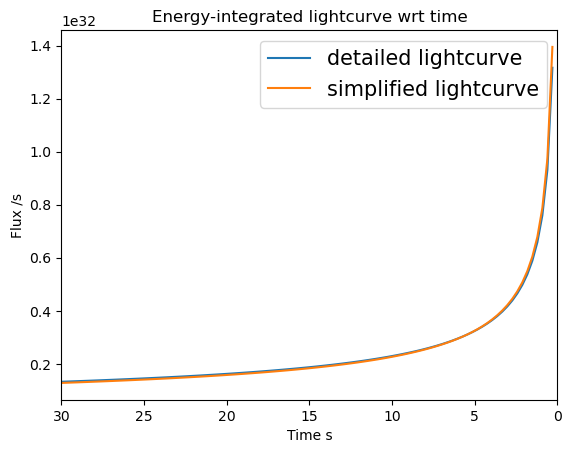

In [5]:
tau = np.linspace(30,0,100) 

fig, ax = plt.subplots()

# Thank goodness I finally fixed this!!!
# SIKE I did not fix it apparently
# Okay, I THINK I did it this time
# Emin and Emax are now tuples
ax.plot(tau, 
        EBH().lightcurve((Emin, Emax), tau = np.linspace(30,0,100)),#np.linspace(Emin, Emax, 100)
        label = 'detailed lightcurve')

ax.plot(tau, 
        lightcurve(tau, normalization = 7.5e31),
        label = 'simplified lightcurve')

ax.set_xlim(30,0)

ax.set_xlabel("Time s")
ax.set_ylabel("Flux /s")
ax.set_title("Energy-integrated lightcurve wrt time")
ax.legend(prop={'size':15})
plt.show()

''

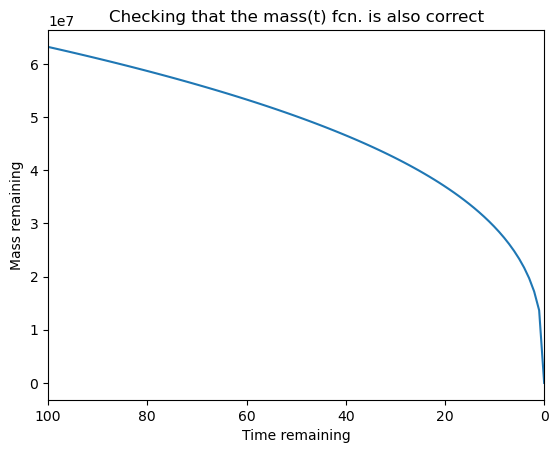

In [6]:
tau = np.linspace(100,0,100)
plt.plot(tau, EBH().convert_ticks(tau))
plt.xlim(100,0)
plt.xlabel('Time remaining')
plt.ylabel('Mass remaining')
plt.title('Checking that the mass(t) fcn. is also correct')
''

### <span id='hard'>Hardness Ratio for LAT/GBM</span>
[To Top](#top)

In [7]:
LAT_e =     (100 * 1e-3, 100)#(20e-3 , 300) #20MeV to 300GeV
GBM_BGO_e = (200 * 1e-6, 40 * 1e-3) #200keV to 40MeV
GBM_NaI_e = (8 * 1e-6  , 1e-3) # 8keV to 1MeV
GBM_e = (30 * 1e-3, 100 * 1e-3)#(GBM_NaI_e[0], GBM_BGO_e[1])

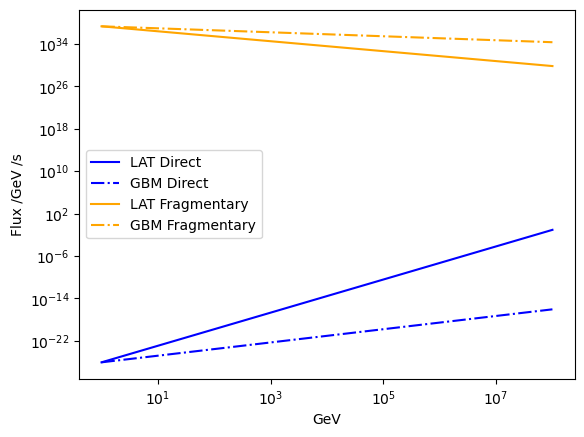

In [8]:
fig, ax = plt.subplots()


LAT_energy_range = np.logspace(-3, 2, 1000)
GBM_energy_range = np.logspace(-3, -1, 1000)

tau = EBH().convert_ticks(mass = 10**5)

LAT_direct = EBH().spectrum(LAT_energy_range, tau=tau, both='primary')
ax.loglog(energy_range, LAT_direct, '-',label = 'LAT Direct', color='blue')

GBM_direct = EBH().spectrum(GBM_energy_range, tau=tau, both='primary')
ax.loglog(energy_range, GBM_direct, '-.',label = 'GBM Direct', color='blue')

LAT_fragmentary = EBH().spectrum(LAT_energy_range, tau=tau, both='secondary')
ax.loglog(energy_range, LAT_fragmentary, '-', label = 'LAT Fragmentary', color='orange')

GBM_fragmentary = EBH().spectrum(GBM_energy_range, tau=tau, both='secondary')
ax.loglog(energy_range, GBM_fragmentary, '-.', label = 'GBM Fragmentary', color='orange')

ax.set_ylabel('Flux /GeV /s')
ax.set_xlabel('GeV')
ax.legend()
plt.show()

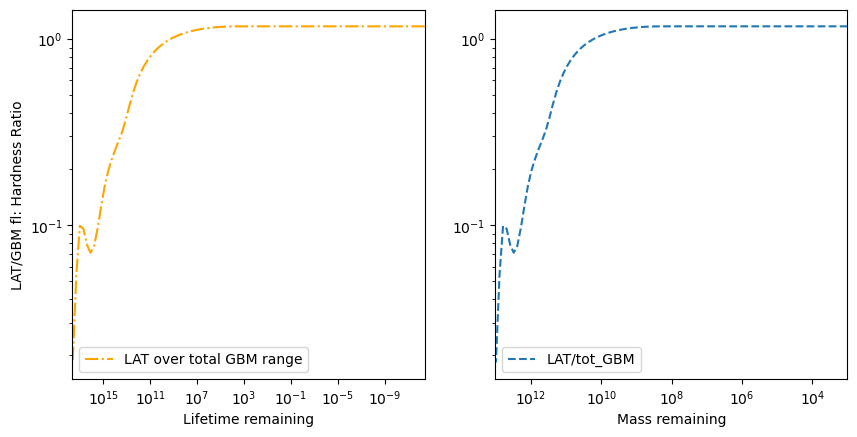

In [9]:
fig, ax = plt.subplots(1,2)

mass = np.logspace(3,13,num=100)

"""
LAT_curve = EBH().lightcurve(
    np.linspace(LAT_e[0], LAT_e[1], 100), tau)

GBM_BGO_curve = EBH().lightcurve(
    np.linspace(GBM_BGO_e[0], GBM_BGO_e[1], 100), tau)

GBM_NaI_curve = EBH().lightcurve(
    np.linspace(GBM_NaI_e[0], GBM_NaI_e[1], 100), tau)

GBM_total_curve = EBH().lightcurve(
    np.linspace(GBM_NaI_e[0], GBM_BGO_e[1], 100), tau)
"""

tau = EBH().convert_ticks(mass = mass)

LAT_curve = EBH().lightcurve( (LAT_e[0], LAT_e[1]), mass = mass)

#GBM_BGO_curve = EBH().lightcurve( (GBM_BGO_e[0], GBM_BGO_e[1]), tau )

#GBM_NaI_curve = EBH().lightcurve( (GBM_NaI_e[0], GBM_NaI_e[1]), tau )

GBM_total_curve = EBH().lightcurve( (GBM_e[0], GBM_e[1]), mass = mass)

ax[0].loglog(tau, LAT_curve/GBM_total_curve, '-.', label='LAT over total GBM range', color = 'orange')
#ax[0].plot(tau, LAT_curve/GBM_BGO_curve, '-.', label='... over GBM BGO', color='blue')
#ax[0].plot(tau, LAT_curve/GBM_NaI_curve, '-.', label='... over GBM NaI', color='green')
ax[0].set_xlim(tau.max()*1.05,tau.min())
ax[0].legend()
ax[0].set_xlabel('Lifetime remaining')
ax[0].set_ylabel('LAT/GBM fl: Hardness Ratio')


#mass = EBH().convert_ticks(tau=tau)
ax[1].loglog(mass, LAT_curve/GBM_total_curve, '--', label = 'LAT/tot_GBM')
ax[1].set_xlim(mass.max() *1.05, mass.min())
ax[1].set_xlabel('Mass remaining')
ax[1].legend()

fig.set_figwidth(10)
fig.show()

### <span id='t90'>Expected T90</span>
[To Top](#top)

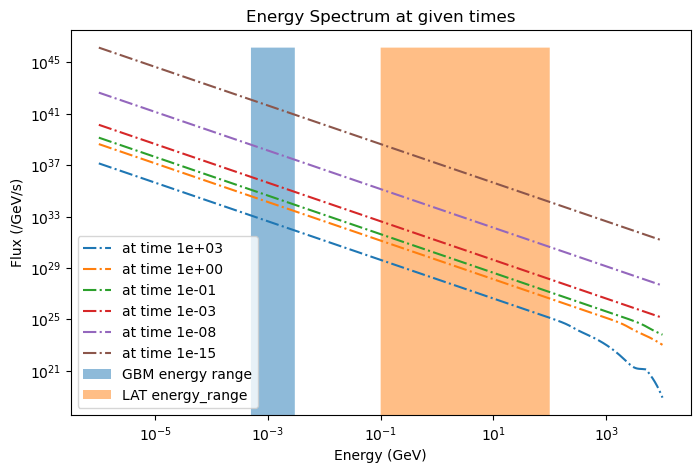

In [10]:
# Our energy ranges are:
GBM_e = (50*10e-6, 300*10e-6)
LAT_e = (0.1, 100)

# Let's show what that looks like!

fig, ax = plt.subplots()

ax.set_title('Energy Spectrum at given times')

mx = 0
for time in [1e3,1,1e-1,1e-3,1e-8,1e-15]:
    energy_linspace = np.linspace(10**(-6), 10**4, 1000)
    full_lc = EBH().spectrum(energy_linspace, time)
    ax.loglog(energy_linspace, full_lc, '-.', label='at time %.e'%time)
    if full_lc.max()>mx:
        mx = full_lc.max()

# GBM only
energy_linspace = np.linspace(GBM_e[0], GBM_e[1], 1000)
#GBM_lc = EBH().spectrum(energy_linspace, 1e-3)
ax.fill_between(energy_linspace, 0, mx, alpha=0.5, label = 'GBM energy range')

# LAT only
energy_linspace = np.linspace(LAT_e[0], LAT_e[1], 1000)
#LAT_lc = EBH().spectrum(energy_linspace, 1e-3)
ax.fill_between(energy_linspace, 0, mx, alpha=0.5, label = 'LAT energy_range')

ax.set_xlabel('Energy (GeV)')
ax.set_ylabel('Flux (/GeV/s)')

ax.legend()
fig.set_figwidth(8)
fig.set_figheight(5)

LAT intersect at energy 8.43e+30, time 0.10
GBM intersect at energy 9.59e+32, time 0.10


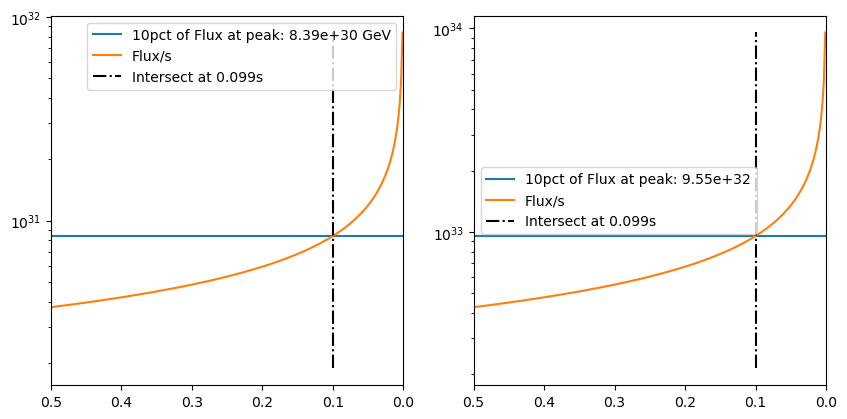

In [11]:
"""
Stefano's SMMass mass definition approach
"""
alphaSM = 8.3* 1e17
M0 = 1e7

tau = lambda M0: M0**3/(3 * alphaSM)

# mass as a function of time to explosion
SMMass = lambda time: (M0**3 - 3 * alphaSM * (tau(M0) - time))**(1/3)


"""
Tweaking of resolution/t=0
This is the part that confuses me: lim EBH_flux as x->0 = inf
Sampling closer to the peak will give higher flux values.
Therefore, the time-to-peak will shorten.
"""
# No. of time-ticks.
time_resolution = 1000
# No. of  ticks to integrate energy over.
#energy_resolution = 100
# Where to consider "t=0"
t_0 = 1e-3


tau = np.linspace(2,t_0,time_resolution)
# Optionally, use Stefano's SMMass time. Essentially identical
#tau = EBH().convert_ticks( mass = SMMass(np.linspace(1e3,t_0,time_resolution)))#,endpoint=False)) )

"""
Seems like the strategy here is to generate a numner where 0.1 max fluence is passed.
From there, we can assume the rest of the time to peak is the signal duration.
"""

_ = EBH().lightcurve((LAT_e[0], LAT_e[1]), [t_0])[0]

LAT_F = (0.1*_, 0.9*_)

_ = EBH().lightcurve((GBM_NaI_e[0], GBM_BGO_e[1]), [t_0])[0]

GBM_F = (0.1*_, 0.9*_)

#print(LAT_F)
#print(GBM_F)



fig, ax = plt.subplots(1,2)
fig.set_figwidth(10)


#### LAT

# 10% of the flux at peak emission. This corresponds to the lower-bound for T90 to begin.
ax[0].plot(tau, 
           np.ones(time_resolution)*LAT_F[0], 
           label = '10pct of Flux at peak: %.2e GeV'%LAT_F[0])

# Generate lightcurve
lc_LAT = EBH().lightcurve((LAT_e[0], LAT_e[1]), tau)
ax[0].plot(tau, lc_LAT, label = 'Flux/s')
#ax[0].plot(tau, lightcurve(tau,energy_range = np.linspace(Emin, Emax, 1000), normalization = 7.3e30))
"""
# Calculate 10% of the peak flux
_ = lc_LAT.max()
LAT_F = (0.1*_, 0.9*_)
"""
# Find the intersection between Lightcurve and the 10% peak flux
intersect = np.where(lc_LAT > LAT_F[0])[0][0]
ax[0].plot(np.ones(2)*tau[intersect], [lc_LAT.min(), lc_LAT.max()], '-.', color='black',
           label = 'Intersect at %.3fs'%tau[intersect])

print('LAT intersect at energy %.2e, time %.2f'%(lc_LAT[intersect], tau[intersect]))

ax[0].legend()
ax[0].set_xlim(.5,0)
ax[0].set_yscale('log')



#### GBM
ax[1].plot(tau, 
           np.ones(time_resolution)*GBM_F[0], 
           label = '10pct of Flux at peak: %.2e'%GBM_F[0])

lc_GBM = EBH().lightcurve((GBM_NaI_e[0], GBM_BGO_e[1]), tau)
ax[1].plot(tau, lc_GBM, label = 'Flux/s')
#ax[1].plot(tau, lightcurve(tau,energy_range = np.linspace(Emin, Emax, 1000), normalization = 9e36))
"""
_ = lc_GBM.max()
GBM_F = (0.1*_, 0.9*_)
"""
intersect = np.where(lc_GBM > GBM_F[0])[0][0]
ax[1].plot(np.ones(2)*tau[intersect], [lc_GBM.min(), lc_GBM.max()], '-.', color='black',
           label = 'Intersect at %.3fs'%tau[intersect])

print('GBM intersect at energy %.2e, time %.2f'%(lc_GBM[intersect], tau[intersect]))

ax[1].legend()
ax[1].set_xlim(.5,0)
ax[1].set_yscale('log')

### <span id='aniso'>Expected Anisotropy Ratio</span>
[To Top](#top)

In [19]:
dist = 8500
rs = 8100

pi = 3.14159

RhoNFW = lambda r: rs**3/(r*(rs+r)**2)
Radius = lambda r, theta: r**2 + dist**2 - 2*r*dist*np.cos(theta)

#r = np.logspace(0.0001, 1, 100)
#cos = np.linspace(1,0, 100)
#r, cos = np.meshgrid(r, cos, indexing='ij')
GC = integrate.nquad(lambda r, theta: RhoNFW(Radius(r, theta)), [[.0001,1], [0,pi/2]])
#GC = I.quad(I.trapz(RhoNFW(Radius(r,cos))))

#r = np.logspace(0.0001, 1, 100)
#cos = np.linspace(0, -1, 100)
#r, cos = np.meshgrid(r, cos, indexing='ij')
#GAC = I.trapz(I.trapz(RhoNFW(Radius(r,cos))))
GAC = integrate.nquad(lambda r, theta: RhoNFW(Radius(r, theta)), [[.0001,1], [pi/2,pi]])

GC = GC[0]
GAC = GAC[0]

#print(GC)
#print(GAC)

print((GC - GAC)/(GAC + GC) * 100)

0.022469489713603918


------
### Testing

In [68]:
x = lambda egamma, MBH: egamma/(1.058 *(10**10/MBH))

# (* parameterization in Eq. (31-34) of 1510/.04372 *)

Aparam = 6.339 * 10**23
Bparam = 1.1367 * 10**24
ThetaS = lambda u: 0.5*(1. + np.tanh(10.*u))

def d2NdEdtfrag(egamma, MBH):
    return (
    Aparam * x(egamma, MBH )*(1 - ThetaS(x(egamma, MBH ) - 0.3)) + 
    Bparam*np.exp( -x(egamma, MBH) ) * 
    ThetaS( x(egamma, MBH) - 0.3 ) /
    (x(egamma, MBH) * (x(egamma, MBH) + 1))
    )

def Ffunc(y):
    f = np.exp(-0.0962 - 1.982 * (np.log(y) - 1.908)*(1. + np.tanh(20.*(np.log(y) - 1.908))))
    try:
        f[np.where(y<2)] = 1
    except:
        if y<2:
            return 1
    return f


def d2NdEdtdirect(egamma, MBH) :
    return (1.13 * 10**19 * (x(egamma, MBH))**6)/(np.exp(x(egamma, MBH)) - 1.) * Ffunc(x(egamma, MBH ))

PhotonFlux = lambda MBH, E_min, E_max: integrate.quad( 
    lambda egamma, MBH: d2NdEdtdirect(egamma, MBH) + d2NdEdtfrag(egamma, MBH), E_min, E_max, (MBH) )[0]

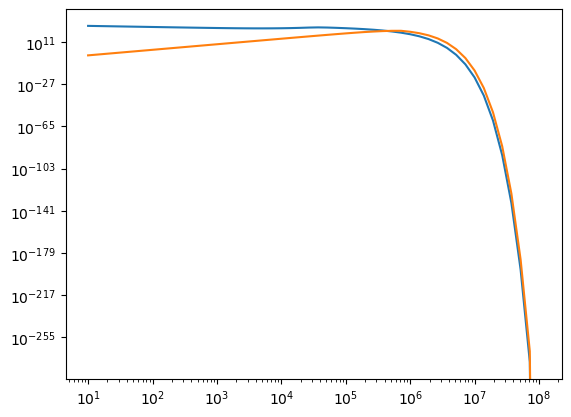

In [62]:
eg = np.logspace(1, 8)
MBHl = 10**5
plt.loglog(eg, d2NdEdtfrag(eg, MBHl), label = 'Frag')
plt.loglog(eg, d2NdEdtdirect(eg, MBHl), label = 'Frag')

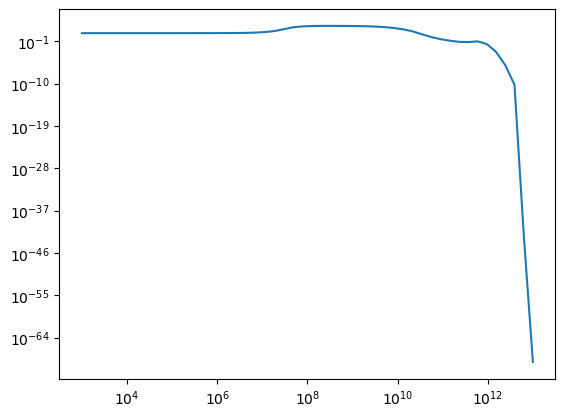

In [70]:
MPBH = np.logspace(3, 13)
"""LogLogPlot[
 PhotonFlux[MPBH, 100 10^-3, 100]/
  PhotonFlux[MPBH, 30 10^-3, 100 10^-3], {MPBH, 10^3, 10^13}"""
scatter = []
for m in MPBH:
  scatter.append( PhotonFlux( m, 100*10**(-3), 100 ) / PhotonFlux( m, 30*10**(-3), 100*10**(-3) ) )
plt.loglog(MPBH, scatter)